<center><h1> Diabetic Retinopathy Detection by Retinal segmentation with Region merging using CNN </h1></center>

<center><h3>Introduction</h3></center>

Diabetic retinopathy is a state of eye infirmity in which  damage  arises  due  to  diabetes  mellitus.  It  is  one  of  the  prominent  reasons  behind  blindness.  Most  of  new  cases  of  diabetic retinopathy can get reduced with proper treatment of eyes

_Ref_: https://ieeexplore.ieee.org/document/8721315

**What is Fundus Image?**

Fundus photography is the process of taking serial photographs of the interior of your eye through the pupil.

_Ref_: https://www.medicinenet.com/what_is_the_purpose_of_fundus_photography/article.htm

**Retinal vessel segmentation**

Retinal vessel segmentation is one of the most important areas of retinal image analysis because some attributes of retinal vessels are usually important symptoms of diseases

_Ref_: https://www.degruyter.com/document/doi/10.1515/bmt-2020-0089/html

![sample](https://www.researchgate.net/publication/228072129/figure/fig1/AS:202518387793921@1425295554317/Manual-vessel-segmentation-a-a-typical-retinal-image-b-manually-segmented-vessels.png "sample")

<center><i>Source</i>: researchgate</center>

**Stages Of Diabetic Retinopathya**  

**Mild nonproliferative retinopathy**

During the early stage of the disease microaneurysms occures. microaneurysms are small areas where balloon-like swelling occurs in the blood vessels of the retina. It causes the fluid to leak into the retina.

**Moderate**

nonproliferative retinopathy.While the disease advances, the blood vessels begin to swell and distort. This completely affects their ability to transport blood. These conditions incite change in the appearance of the retina. 

**Severe**

nonproliferative retinopathy.During this state blood vessels gets completely blocked. This seizes blood supply to areas of the retina. These areas disguise growth factors and gives signal the retina to grow new blood vessels.

**Proliferative diabetic retinopathy (PDR)**

This is the highest stage of severity of diabetic retinopathy. At this stage, the growth factor triggers the retina to form new blood vessels. These new blood vessels are fragile and are likely to leak and bleed. This lead to the contraction of scar tissues which causes retinal detachment. Retinal detachment is a process of ripping away of the retina from the underlying tissue. The retinal detachment can cause permanent vision loss.


_Ref_: https://ieeexplore.ieee.org/document/8721315

In [1]:
# Import Requried Libaries
import os
import cv2
import imageio
import numpy as np
import warnings

warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define paths
train = "DRIVE/training"
test = "DRIVE/test"

### Initial Preprocessing

1. Read Image
2. Extract Green Channel only
3. Image Enhancement using Contrast Limited Adaptive Histogram Equalization(CLAHE) technique
4. Subtract the black background
5. Merge the retinal segment

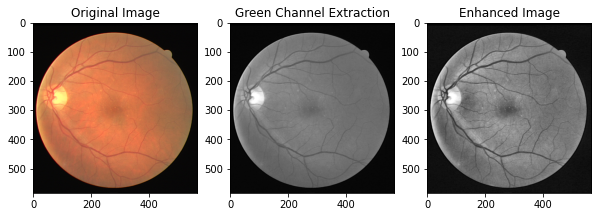

In [3]:
# Read Image
image = cv2.imread(f"{train}/images/21_training.tif")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Extract Green Channel
R, G, B = cv2.split(image)

# CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enh_img = clahe.apply(G)
cv2.imread(f"{train}/images/21_training.tif")

# Plot
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("Original Image")
ax1.imshow(image)

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("Green Channel Extraction")
ax2.imshow(G, cmap="binary_r")

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("Enhanced Image")
ax3.imshow(enh_img, cmap="binary_r")
plt.show()

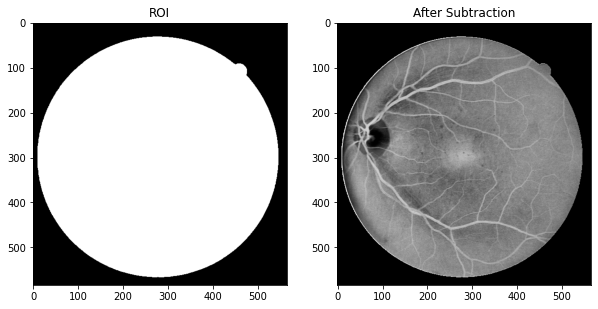

In [4]:
# Reading roi
roi = imageio.mimread(f"{train}/mask/21_training_mask.gif")[0]
roi = np.array(roi)

# subtract backgroud
sub = enh_img * roi

# Plot
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("ROI")
ax1.imshow(roi, cmap="binary_r")

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("After Subtraction")
ax2.imshow(sub, cmap="binary_r")
plt.show()

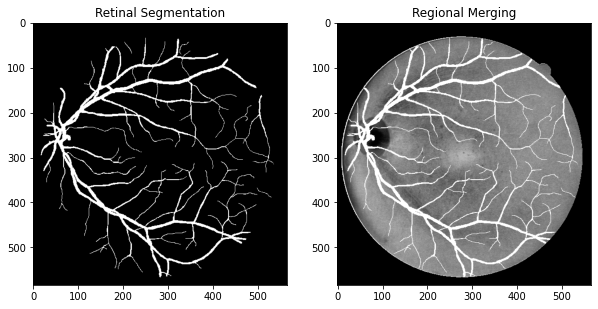

In [5]:
# Read Annotation
seg = imageio.mimread(f"{train}/1st_manual/21_manual1.gif")[0]
seg = np.array(seg)

# Merge Region
regional_merge = cv2.add(seg, sub)

# Plot
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Retinal Segmentation")
ax1.imshow(seg, cmap="binary_r")

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Regional Merging")
ax2.imshow(regional_merge, cmap="binary_r")
plt.show()

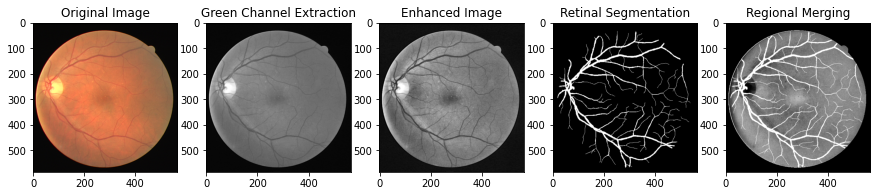

In [6]:
# Overview
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(1, 5, 1)
ax1.set_title("Original Image")
ax1.imshow(image)

ax2 = fig.add_subplot(1, 5, 2)
ax2.set_title("Green Channel Extraction")
ax2.imshow(G, cmap="binary_r")

ax3 = fig.add_subplot(1, 5, 3)
ax3.set_title("Enhanced Image")
ax3.imshow(enh_img, cmap="binary_r")

ax4 = fig.add_subplot(1, 5, 4)
ax4.set_title("Retinal Segmentation")
ax4.imshow(seg, cmap="binary_r")

ax5 = fig.add_subplot(1, 5, 5)
ax5.set_title("Regional Merging")
ax5.imshow(regional_merge, cmap="binary_r")
plt.show()

### ROI Generation

In DRIVE dataset we have mask where we can subtract it from the image but when coming to kaggle set we will not be having the mask inorder to subtract it from, so we need to generate the mask.

Retinal region is circular even though fundus images are rectangular. Therefore, retinal region masks must be utilized in order to select the region of interest in fundus images. 

_Ref_: https://www.hindawi.com/journals/jhe/2017/4897258/

**Process**

1. Read Image & Convert it to GRAY
2. Compute the histogram of the image
3. Smooth histogram to remove noise
4. Find the Peaks & Valley in histogram
5. Find Local minima and maximus, Instead compute minima and maximus, we directly get deviation of peaks as threshold for mask generation

_Ref_: https://www.researchgate.net/publication/332263231_Generation_of_binary_mask_of_retinal_fundus_image_using_bimodal_masking

In [10]:
def smooth(x,window_len=11,window='hanning'):
    #Ref: https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html

    if x.ndim != 1:
        raise ValueError

    if x.size < window_len:
        raise ValueError


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [18]:
image_g = G.copy()

In [7]:
from scipy.signal import find_peaks

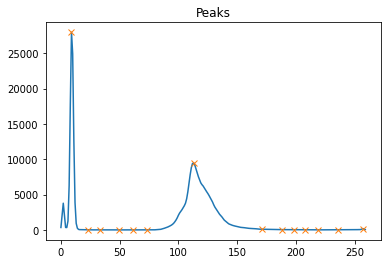

In [14]:
# Histogram
hist = cv2.calcHist([image_g], [0], None, [256], [0, 256])

# Smooth Histogram
hist_smooth = smo_hist = smooth(hist.ravel(), 5)

# Find peaks
peaks, _ = find_peaks(hist_smooth, distance=10)

plt.title("Peaks")
plt.plot(hist_smooth)
plt.plot(peaks, hist_smooth[peaks], "x")
plt.show()

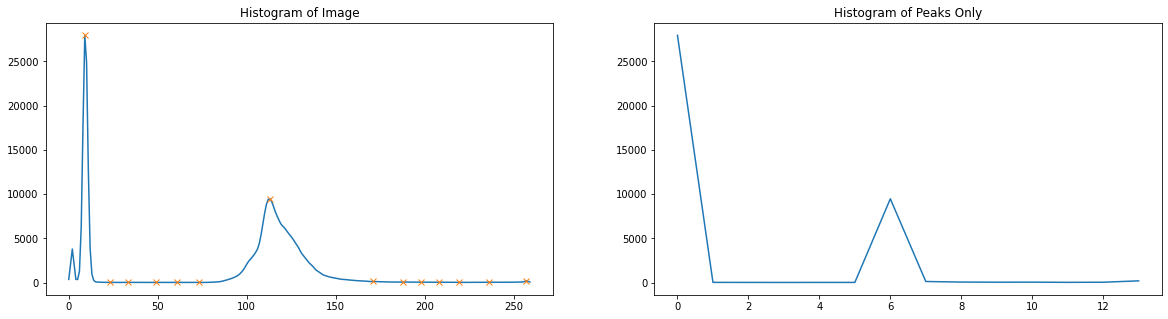

In [15]:
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Histogram of Image")
ax1.plot(hist_smooth)
ax1.plot(peaks, hist_smooth[peaks], "x")

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Histogram of Peaks Only")
ax2.plot(hist_smooth[peaks])
plt.show()

In [17]:
# Threshold
threshold = np.std(image_g[peaks])
print(f"Threshold: {threshold:.2f}")

# Mask
binary_roi = (image_g > threshold)

# Convert back to binary Image
binary_roi = binary_roi.astype("uint8")

Threshold: 59.82


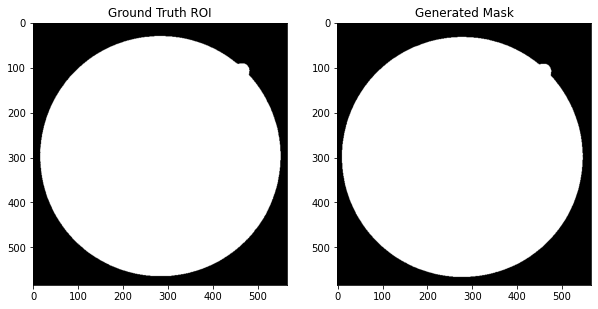

In [20]:
true_roi = imageio.mimread(f"{test}/mask/01_test_mask.gif")[0]
true_roi = np.array(true_roi)

# Plot
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Ground Truth ROI")
ax1.imshow(true_roi, cmap="binary_r")

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Generated Mask")
ax2.imshow(binary_roi, cmap="binary_r")
plt.show()

#### Stacking Back All for single plot

In [21]:
G = cv2.cvtColor(G, cv2.COLOR_GRAY2RGB)
enh_img = cv2.cvtColor(enh_img, cv2.COLOR_GRAY2RGB)
true_roi = cv2.cvtColor(true_roi, cv2.COLOR_GRAY2RGB)
seg = cv2.cvtColor(seg, cv2.COLOR_GRAY2RGB)
regional_merge = cv2.cvtColor(regional_merge, cv2.COLOR_GRAY2RGB)

In [22]:
stacked = np.hstack((image, G, enh_img, true_roi, seg, regional_merge))

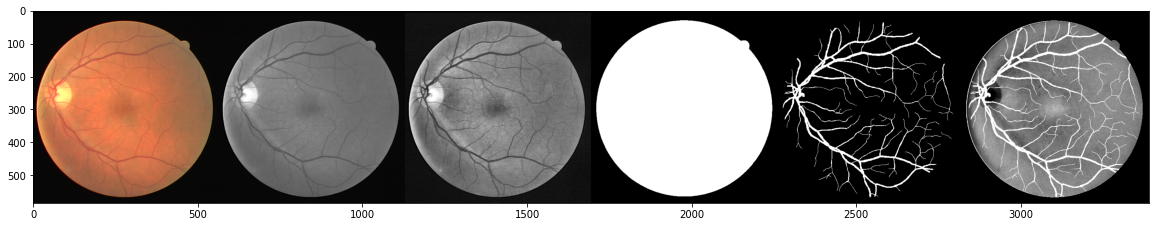

In [27]:
fig = plt.figure(figsize=(20, 20))
plt.imshow(stacked)
# plt.savefig("Header.png")
plt.show()